In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv

from helper import *

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

In [2]:
n_CPU = 12

# 1. Load the data

#### 10% raw dataset

In [3]:
df_raw = load_data(path_pos='train_pos.txt', path_neg='train_neg.txt')

(91088, 2)
(90233, 2)
(181321, 2)


#### Full raw dataset

In [4]:
df_train_full = load_data(path_pos='train_pos_full.txt', path_neg='train_neg_full.txt')

(1142838, 2)
(1127644, 2)
(2270482, 2)


In [5]:
f = open('test_data.txt', "r",encoding="utf8")
data_test = f.read().split('\n')
df_test = pd.DataFrame(data_test, columns = ['tweet'])
df_test.drop(df_test.tail(1).index,inplace=True)

# 2. Classic ML approach

## 2.1 Encoding

In [6]:
full = input('True for using the full dataset, 10% of the dataset otherwise?')

True for using the full dataset, 10% of the dataset otherwise?False


In [7]:
df_train_full = df_train_full.sample(df_train_full.shape[0])
df_raw = df_raw.sample(df_raw.shape[0])

if eval(full):
    X_raw = df_train_full['tweet']
    y_raw = df_train_full['sentiment']
else:
    X_raw = df_raw['tweet']
    y_raw = df_raw['sentiment']

In [8]:
def hyperparameter_tuning(model, name, X, y, encoding=True, n_splits=5, n_jobs_cross=n_CPU, list_of_kwargs=[], **kwargs):
    '''
    Function enabling us to do some hyperparameters tuning on any model using cross validation.
    
    Imput:
        model: Sklearn model that we want to use
        name: Name of the model, string
        X: Matrix of regressors, numpy.ndarray
        y: Labels, numpy.array
        encoding=True: Argument to choose whether we want to optimize the encoding part of the machine learning part
        n_jobs_cross=n_CPU: Number of CPU to use for the cross validation
        list_of_kwargs=[]: List of arguments to test against each other, formatting as a list of kwargs to be able to 
    choose which argument we which to optimize
        kwargs: Other arguments that might be relevant for the models
    
    Output:
        Plot of the cross validation results as a boxplot
        Output the best parameter
    
    '''
    model_results = []
    model_names = []
    model_results_mean = []

    for kw in list_of_kwargs:
        kfold = model_selection.KFold(n_splits, random_state=42)
        if encoding: #Hyperparameter tuning on the encoding parameters
            start_time = time.time()
            pipe = make_pipeline(CountVectorizer(**kwargs, **kw), TfidfTransformer())
            pipe.fit(X)
            feat = pipe.transform(X)
            test_results = model_selection.cross_val_score(model, feat, y, cv=kfold, n_jobs=n_jobs_cross)
        else:
            start_time = time.time()
            test_results = model_selection.cross_val_score(model(**kw, **kwargs), X, y, cv=kfold, n_jobs=n_jobs_cross)
        model_results.append(test_results)
        model_results_mean.append(test_results.mean())
        name_ = str(list(kw.keys())[0])+'='+str(list(kw.values())[0])
        model_names.append(list(kw.values())[0])
        time_length = time.time() - start_time
        msg = "%s: %f (std: %f, time: %f)" % (name_, test_results.mean(), test_results.std(), time_length)
        print(msg)
    
    fig = plt.figure()
    fig.suptitle('Hyperparameter tuning for '+str(str(list(kw.keys())[0])))
    ax = fig.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names)
    if encoding:
        plt.savefig('./figure/hyperparameter_tuning/feature_encoding/Hyperparameter tuning for '+str(str(list(kw.keys())[0]))+'.jpg')
    else:
        plt.savefig('./figure/hyperparameter_tuning/Hyperparameter tuning for '+str(str(list(kw.keys())[0]))+'.jpg')
    plt.show()
    
    return list_of_kwargs[np.argmax(model_results_mean)]

#### ngram_range

In [15]:
list_ngram_range = [{'ngram_range':(i,j)} for i in range(1,4) for j in range(i,4)]

ngram_range=(1, 1): 0.795981 (std: 0.001639, time: 9.445796)
ngram_range=(1, 2): 0.807430 (std: 0.001786, time: 20.626566)
ngram_range=(1, 3): 0.801452 (std: 0.001198, time: 37.195328)
ngram_range=(2, 2): 0.769712 (std: 0.000831, time: 15.837309)
ngram_range=(2, 3): 0.761544 (std: 0.001371, time: 31.240721)
ngram_range=(3, 3): 0.700487 (std: 0.002066, time: 19.773431)


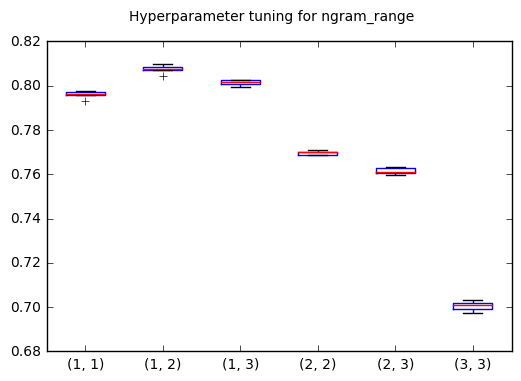

In [16]:
best_ngram_range = hyperparameter_tuning(LogisticRegression(n_jobs=n_CPU) , 'Logistic', X_raw, y_raw, n_splits=5, n_jobs_cross=n_CPU, list_of_kwargs=list_ngram_range, binary=True, stop_words=None, analyzer='word')

#### Max_features

In [12]:
list_max_features = [{'max_features':10000*i} for i in range(5,15)]

max_features=50000: 0.833586 (std: 0.000974, time: 394.825337)
max_features=60000: 0.835213 (std: 0.000983, time: 414.413738)
max_features=70000: 0.836377 (std: 0.001013, time: 409.830917)
max_features=80000: 0.837340 (std: 0.000939, time: 415.393936)
max_features=90000: 0.838089 (std: 0.000852, time: 431.109786)
max_features=100000: 0.838759 (std: 0.000884, time: 427.308712)
max_features=110000: 0.839300 (std: 0.000824, time: 417.025713)
max_features=120000: 0.839845 (std: 0.000816, time: 420.320445)
max_features=130000: 0.840259 (std: 0.000804, time: 426.127053)
max_features=140000: 0.840523 (std: 0.000737, time: 429.125541)


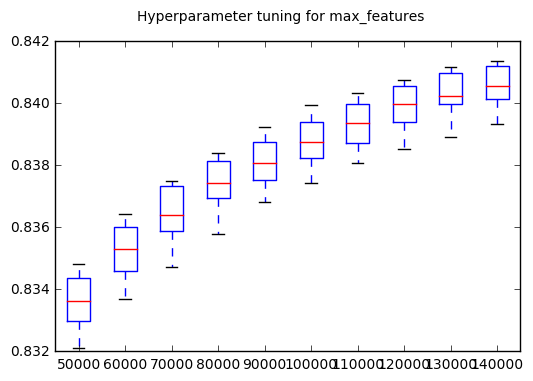

In [17]:
best_max_features = hyperparameter_tuning(LogisticRegression(n_jobs=n_CPU), 'Logistic', X_raw, y_raw, n_splits=5, n_jobs_cross=n_CPU, list_of_kwargs=list_max_features, binary=True, stop_words=None, analyzer='word', ngram_range=best_ngram_range['ngram_range'])

#### Best pipe parameters 

In [9]:
#Saved best parameters
#pipe = make_pipeline(CountVectorizer(ngram_range=(1,3), analyzer='word', binary=True, max_features=140000), TfidfTransformer())

In [11]:
#Best Pipe parameters and save the feature vectors
pipe = make_pipeline(CountVectorizer(stop_words=None, ngram_range=best_ngram_range['ngram_range'], analyzer='word', binary=True, max_features=best_max_features['max_features']), TfidfTransformer())
pipe.fit(X_raw)
feat_train_raw = pipe.transform(X_raw)
feat_test_raw= pipe.transform(df_test['tweet'])

In [181]:
#np.save('feat_train', feat_train_raw)
#np.save('feat_test', feat_test_raw)
#np.save('y_raw', y_raw)

## Hyperparameter tuning on the classifiers

#### Random Forest Hyperparameters

In [21]:
list_n_estimator = [{'n_estimators':n} for n in np.linspace(20,120,10,dtype = 'int32')]

n_estimators=20: 0.775591 (std: 0.001070, time: 105.465966)
n_estimators=31: 0.780842 (std: 0.001691, time: 162.390553)
n_estimators=42: 0.784741 (std: 0.002461, time: 219.955684)
n_estimators=53: 0.784498 (std: 0.000910, time: 276.603017)
n_estimators=64: 0.787410 (std: 0.000518, time: 334.267284)
n_estimators=75: 0.786638 (std: 0.001733, time: 392.318745)
n_estimators=86: 0.788166 (std: 0.001831, time: 448.542005)
n_estimators=97: 0.788282 (std: 0.001702, time: 511.341755)
n_estimators=108: 0.789495 (std: 0.002137, time: 566.280877)
n_estimators=120: 0.788701 (std: 0.001974, time: 629.371104)


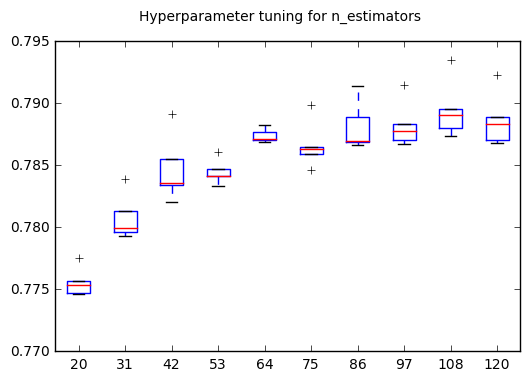

In [22]:
best_rf_n_estimator = hyperparameter_tuning(RandomForestClassifier, 'Random forest with n_estimator = ', feat_train_raw, y_raw, encoding=False, list_of_kwargs=list_n_estimator, n_splits=5, n_jobs_cross=12, n_jobs=12)

#### Naïve Bayes

In [23]:
list_alpha = [{'alpha':alpha} for alpha in np.linspace(0,0.99,10)]

alpha=0.0: 0.773854 (std: 0.001210, time: 1.710654)
alpha=0.11: 0.783274 (std: 0.001317, time: 1.698256)
alpha=0.22: 0.784239 (std: 0.001090, time: 1.668296)
alpha=0.33: 0.784553 (std: 0.001119, time: 1.713757)
alpha=0.44: 0.784757 (std: 0.000983, time: 1.716391)
alpha=0.55: 0.784956 (std: 0.000909, time: 1.731945)
alpha=0.66: 0.784796 (std: 0.000925, time: 1.701656)
alpha=0.77: 0.784901 (std: 0.000890, time: 1.718795)
alpha=0.88: 0.784995 (std: 0.001046, time: 1.719534)
alpha=0.99: 0.784791 (std: 0.001275, time: 1.696193)


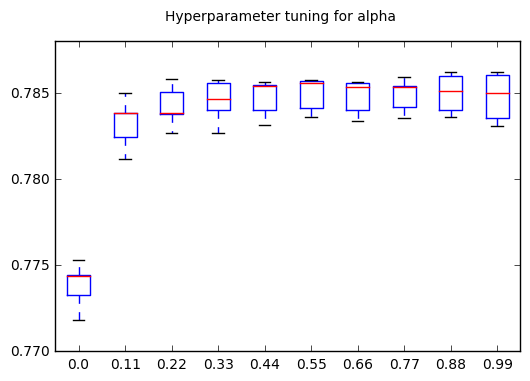

In [24]:
best_nb_alpha = hyperparameter_tuning(MultinomialNB, 'Naïve Bayes with alpha = ', feat_train_raw, y_raw, encoding=False, list_of_kwargs=list_alpha)

#### K Neareast Neighbors Classifier

In [25]:
list_n_neighbors = [{'n_neighbors':n} for n in np.linspace(2,12,11,dtype = 'int32')]

n_neighbors=2: 0.566250 (std: 0.007274, time: 150.721626)
n_neighbors=3: 0.559190 (std: 0.015374, time: 155.036478)
n_neighbors=4: 0.562400 (std: 0.002664, time: 175.233238)
n_neighbors=5: 0.565075 (std: 0.001272, time: 175.954329)
n_neighbors=6: 0.558330 (std: 0.004094, time: 174.909626)
n_neighbors=7: 0.561165 (std: 0.002387, time: 174.977443)
n_neighbors=8: 0.555451 (std: 0.005806, time: 174.923146)
n_neighbors=9: 0.558485 (std: 0.004521, time: 174.849645)
n_neighbors=10: 0.555727 (std: 0.009995, time: 175.103141)
n_neighbors=11: 0.555722 (std: 0.008037, time: 175.049202)
n_neighbors=12: 0.553957 (std: 0.010951, time: 175.100547)


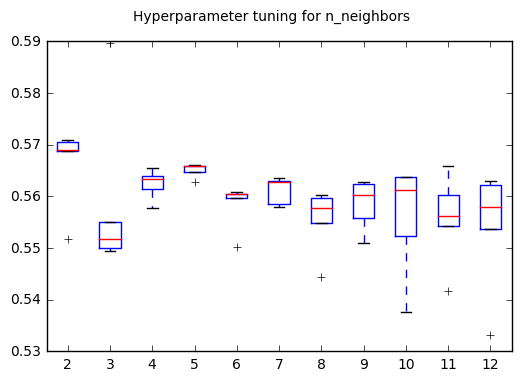

In [26]:
best_knn_n_neighbors = hyperparameter_tuning(KNeighborsClassifier, 'K Nearest neighbors with n_neighbors = ', feat_train_raw, y_raw, encoding=False, list_of_kwargs=list_n_neighbors)

#### SVC classifier

Note, the hyperparameter tuning here has only be done on 5% of the dataset and not 10% due to computationnal constraints.

In [13]:
list_c = [{'C':c} for c in np.linspace(0.01,1,10)]

C=0.01: 0.565180 (std: 0.010778, time: 402.141386)
C=0.12: 0.764420 (std: 0.002634, time: 384.727004)
C=0.23: 0.780280 (std: 0.002662, time: 433.407172)
C=0.34: 0.786320 (std: 0.002438, time: 484.319382)
C=0.45: 0.790440 (std: 0.003315, time: 466.662693)
C=0.56: 0.792100 (std: 0.002993, time: 600.131005)
C=0.67: 0.792860 (std: 0.002731, time: 568.849569)
C=0.78: 0.793060 (std: 0.002181, time: 746.169290)
C=0.89: 0.792860 (std: 0.002189, time: 825.243383)
C=1.0: 0.792100 (std: 0.002579, time: 885.013850)


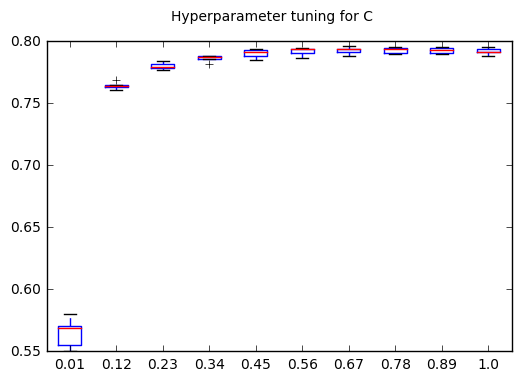

In [28]:
best_svc_linear_c = hyperparameter_tuning(SVC, 'SVC, linear Kernel, with C = ', feat_train_raw, y_raw, kernel='linear', encoding=False, list_of_kwargs=list_c, n_splits = 5)

## Comparison of the different classifiers

In [12]:
#Saved best param
best_svc_linear_c = {'C':0.78}
best_nb_alpha = {'alpha': 0.88}
best_knn_n_neighbors = {'n_neighbors':5}
best_rf_n_estimator = {'n_estimators':108}

LR: 0.813171 (std: 0.002624, time:6.350006)
NB: 0.793648 (std: 0.002180, time:2.183772)
RF: 0.790565 (std: 0.002531, time:3799.679251)
KNN: 0.552109 (std: 0.005641, time:250.037715)
SVC linear: 0.817004 (std: 0.001693, time:9626.312757)


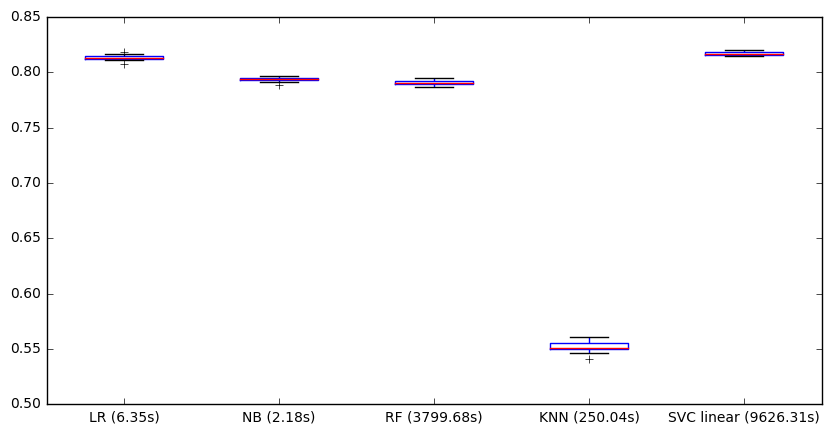

In [17]:
lst_alg = []
lst_alg.append(('LR', LogisticRegression(n_jobs=n_CPU)))
lst_alg.append(('NB', MultinomialNB(**best_nb_alpha)))
#lst_alg.append(('DT', tree.DecisionTreeClassifier()))
lst_alg.append(('RF',RandomForestClassifier(**best_rf_n_estimator, n_jobs=n_CPU)))
lst_alg.append(('KNN', KNeighborsClassifier(**best_knn_n_neighbors, n_jobs=n_CPU)))
lst_alg.append(('SVC linear', SVC(kernel = 'linear', **best_svc_linear_c)))
#lst_alg.append(('SVC polynomial', SVC(kernel = 'poly', **best_svc_poly_c)))
#lst_alg.append(('SVC rbf', SVC(kernel = 'rbf', **best_svc_rbf_c)))
#lst_alg.append(('SVC sigmoid', SVC(kernel = 'sigmoid', **best_svc_sigmoid_c)))

model_results = []
model_names = []

for name, model in lst_alg:
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    start_time = time.time()
    tst_results = model_selection.cross_val_score(model, feat_train_raw, y_raw, cv=kfold, n_jobs=n_CPU)
    time_length = time.time() - start_time
    model_results.append(tst_results)
    model_names.append(name + ' ('+str(np.around(time_length,2)) + 's)')
    msg = "%s: %f (std: %f, time:%f)" % (name, tst_results.mean(), tst_results.std(), time_length)
    print(msg)
    
fig = plt.figure(figsize = (10,5))
#fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(model_results)
ax.set_xticklabels(model_names)
plt.savefig('./figure/classical_ML/Algorithm_comp.jpg')
plt.show()

best_model = lst_alg[np.argmax(np.mean(model_results, axis=1))]

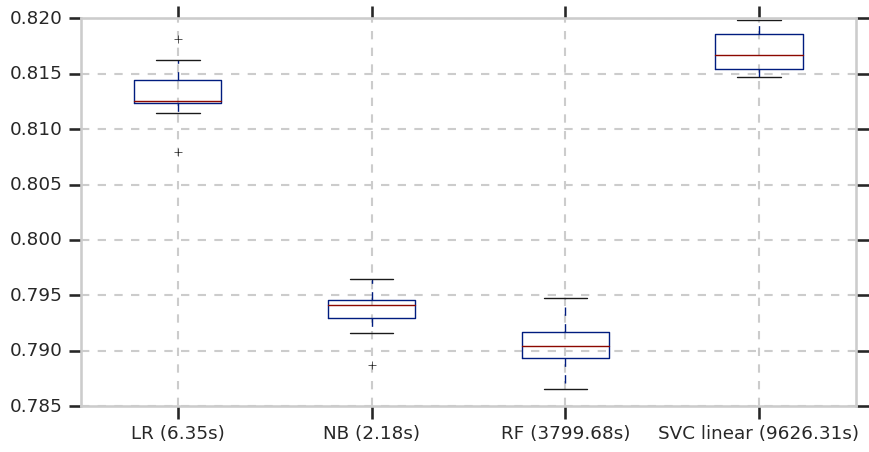

In [69]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.8, font='Ricty',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize = (10,5))
#fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(m_save)
web

plt.savefig('./figure/classical_ML/final_comp.jpg')
plt.show()

best_model = lst_alg[np.argmax(np.mean(model_results, axis=1))]

## Description and comparison of the differents models with their best parameters

In [31]:
#Function used to fit and print some summaries of the model obtained

def fit_and_print_results(clf, X_train, X_test, y_train, y_test, clf_name):
    '''
    This function enables us to obtain more information on each model results, notably a full classification 
    report and confusion matrix. It also enables us to get the True Positive Rate (tpr) and Fall Positive Rate (fpr) which
    will be used to plot the ROC curves.
    
    Input:
        clf: Sklearn classifier
        X_train: Regressors for training the model
        X_test: Regressors for testing the model
        y_train: Labels for training the model
        y_test: Labels for testing the model
        clf_name: Name of the classifier
        
    Output:
        Display the confusion matrix and the classification report as well with the time required to fit the model.
        fpr: False Positive Rate
        tpr: True Positive Rate
        threshold: Thresholds on the decision function used to compute fpr and tpr
        time_length: Time required to fit the model
        
    '''
    start_time = time.time()
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    time_length = time.time() - start_time
    print("The model fitted and predicted in %s seconds" % (time_length))
    print('The accuracy of the model '+clf_name+' is:',accuracy_score(y_test, predicted),'\n')
    print('Classification report for the model '+clf_name+':')
    print(classification_report(y_test, predicted))
    
    fig = plt.figure(figsize=(8,8))
    conf_matrix = confusion_matrix(predicted, y_test)
    sns.heatmap(conf_matrix, annot=True, fmt = "d", square = True, linewidths = 2, linecolor = "w", cmap = "Set2")
    plt.title(clf_name+' confusion matrix')
    plt.show()
    #For plotting the ROC Curve
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test.values, probs)
    return fpr, tpr, threshold, time_length

### Fit of different Machine Learning algorithm

In [32]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(feat_train_raw, y_raw, test_size=0.33, random_state=42)

#### Decision Tree

The model fitted and predicted in 163.03285932540894 seconds
The accuracy of the model Decision tree is: 0.7179457182966776 

Classification report for the model Decision tree:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72     30077
           1       0.71      0.73      0.72     29759

    accuracy                           0.72     59836
   macro avg       0.72      0.72      0.72     59836
weighted avg       0.72      0.72      0.72     59836



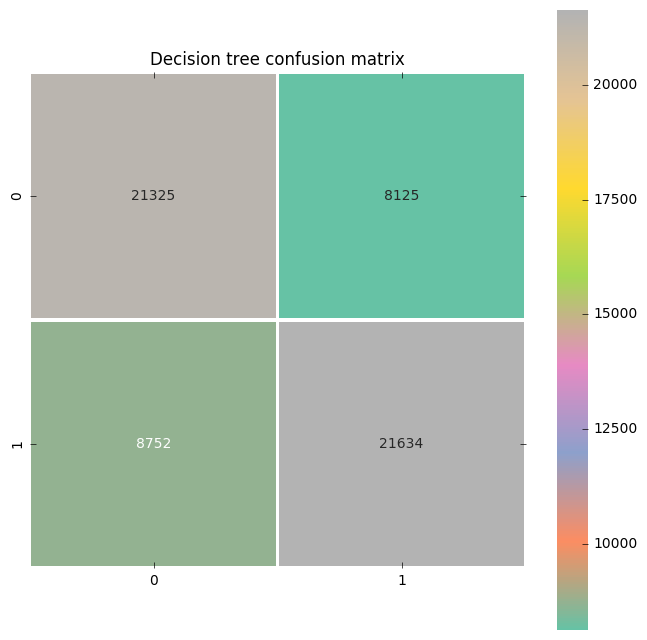

In [33]:
clf_raw_dt = tree.DecisionTreeClassifier()
fpr_raw_dt, tpr_raw_dt, threshold_raw_dt, time_raw_dt = fit_and_print_results(clf_raw_dt, X_train_raw, X_test_raw, y_train_raw, y_test_raw, 'Decision tree')

#### Random Forest

The model fitted and predicted in 198.4974091053009 seconds
The accuracy of the model Random Forest is: 0.7889230563540344 

Classification report for the model Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.72      0.78     30077
           1       0.75      0.85      0.80     29759

    accuracy                           0.79     59836
   macro avg       0.79      0.79      0.79     59836
weighted avg       0.79      0.79      0.79     59836



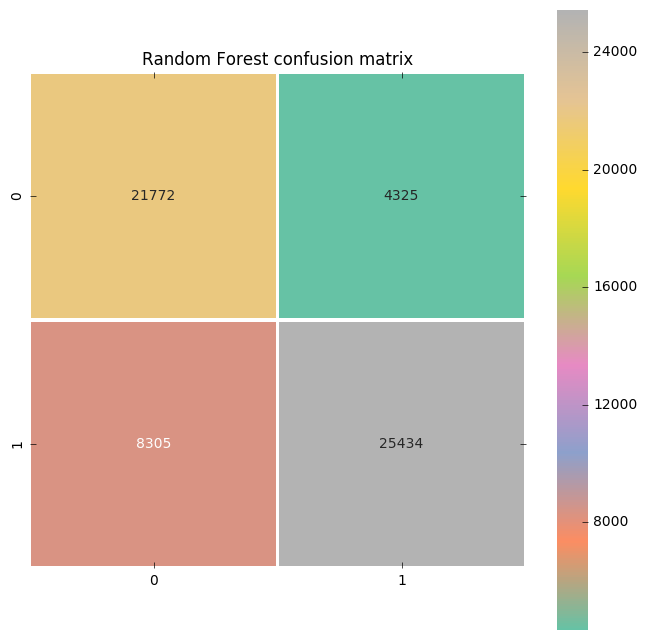

In [34]:
clf_raw_rf = RandomForestClassifier(**best_rf_n_estimator, n_jobs=n_CPU)
fpr_raw_rf, tpr_raw_rf, threshold_raw_rf, time_raw_rf = fit_and_print_results(clf_raw_rf, X_train_raw, X_test_raw, y_train_raw, y_test_raw, 'Random Forest')

#### Naïve Bayes

The model fitted and predicted in 0.056185245513916016 seconds
The accuracy of the model Naïve Bayes is: 0.7906110034093188 

Classification report for the model Naïve Bayes:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     30077
           1       0.75      0.87      0.80     29759

    accuracy                           0.79     59836
   macro avg       0.80      0.79      0.79     59836
weighted avg       0.80      0.79      0.79     59836



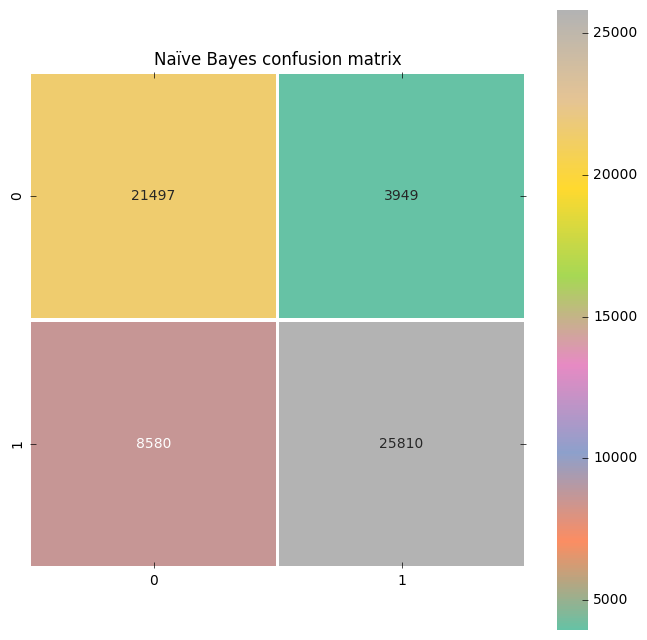

In [35]:
clf_raw_nb = MultinomialNB(**best_nb_alpha)
fpr_raw_nb, tpr_raw_nb, threshold_raw_nb, time_raw_nb = fit_and_print_results(clf_raw_nb, X_train_raw, X_test_raw, y_train_raw, y_test_raw, 'Naïve Bayes')

#### Logistic Regression

The model fitted and predicted in 6.452662706375122 seconds
The accuracy of the model Logistic Regression is: 0.810047463065713 

Classification report for the model Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81     30077
           1       0.80      0.83      0.81     29759

    accuracy                           0.81     59836
   macro avg       0.81      0.81      0.81     59836
weighted avg       0.81      0.81      0.81     59836



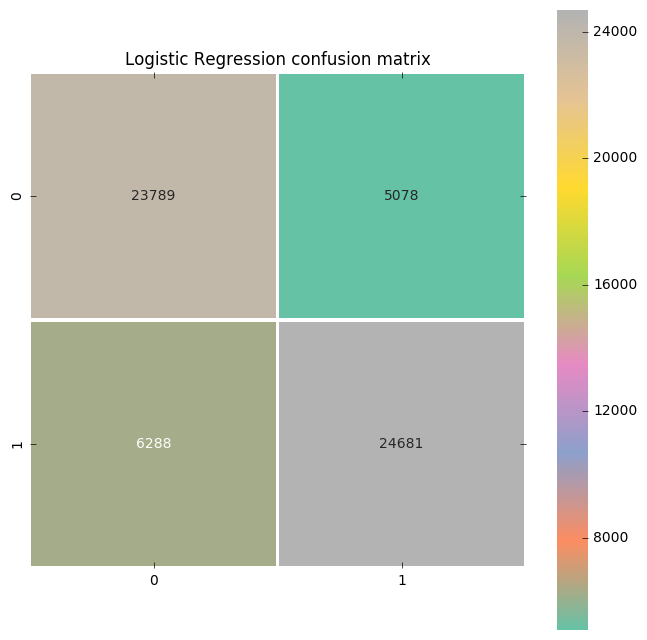

In [36]:
clf_raw_lr = LogisticRegression(solver='lbfgs', n_jobs=n_CPU)
fpr_raw_lr, tpr_raw_lr, threshold_raw_lr, time_raw_lr = fit_and_print_results(clf_raw_lr, X_train_raw, X_test_raw, y_train_raw, y_test_raw, 'Logistic Regression')

#### C-Support Vector Classification

The model fitted and predicted in 3797.049922466278 seconds
The accuracy of the model SVC is: 0.8117521224680794 

Classification report for the model SVC:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     30077
           1       0.80      0.82      0.81     29759

    accuracy                           0.81     59836
   macro avg       0.81      0.81      0.81     59836
weighted avg       0.81      0.81      0.81     59836



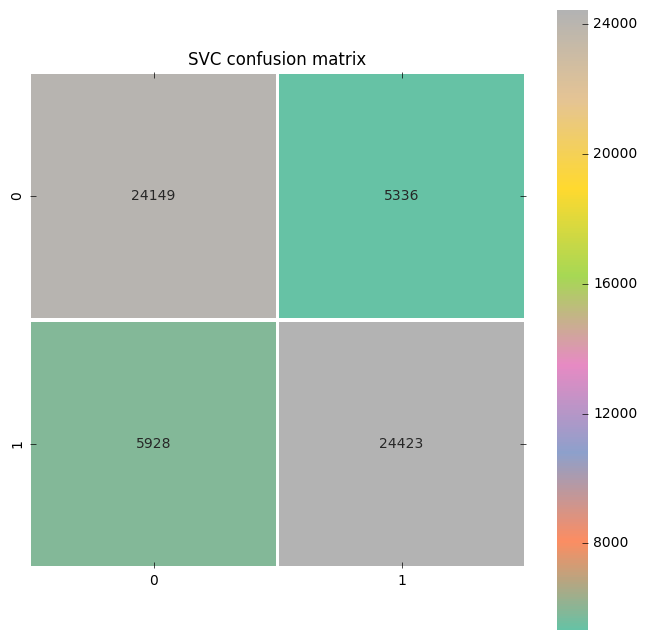

In [ ]:
clf_raw_svc = BaggingClassifier(SVC(**best_svc_linear_c, kernel = 'linear'), n_jobs=n_CPU)
fpr_raw_svc, tpr_raw_svc, threshold_raw_svc, time_raw_svc = fit_and_print_results(clf_raw_svc, X_train_raw, X_test_raw, y_train_raw, y_test_raw, 'SVC')

#### K Nearest neighbors

The model fitted and predicted in 205.4224932193756 seconds
The accuracy of the model K nearest neighbors is: 0.5337756534527709 

Classification report for the model K nearest neighbors:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68     30077
           1       0.87      0.07      0.14     29759

    accuracy                           0.53     59836
   macro avg       0.69      0.53      0.41     59836
weighted avg       0.69      0.53      0.41     59836



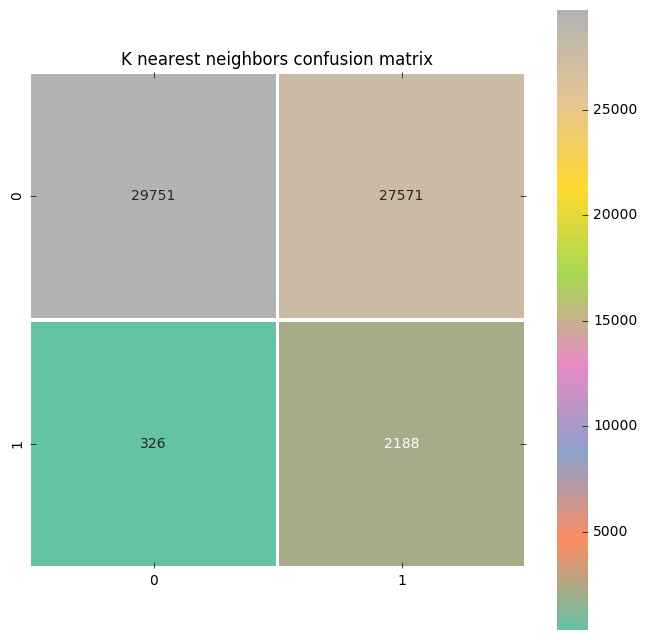

In [ ]:
clf_raw_knn = KNeighborsClassifier(**best_knn_n_neighbors, n_jobs=n_CPU)
fpr_raw_knn, tpr_raw_knn, threshold_raw_knn, time_raw_knn = fit_and_print_results(clf_raw_knn, X_train_raw, X_test_raw, y_train_raw, y_test_raw, 'K nearest neighbors')

### Plot of the ROC curve

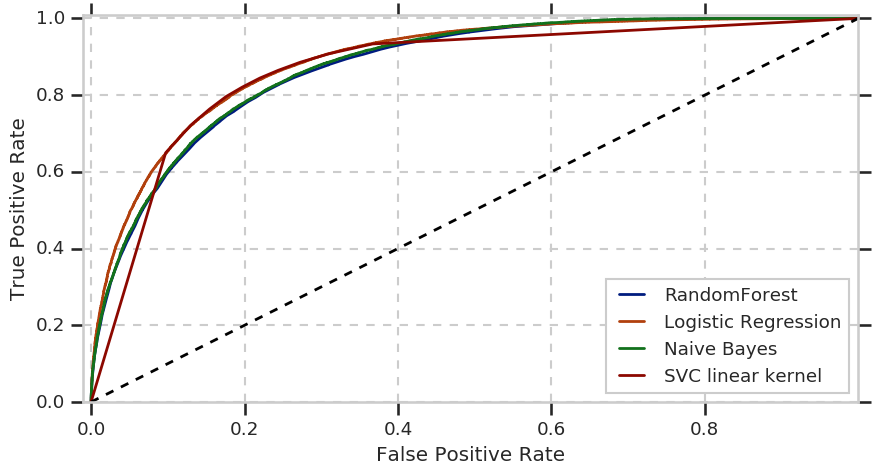

In [68]:
plt.figure(figsize = (10,5))

#Random forest
plt.plot(fpr_raw_rf, tpr_raw_rf, label = 'RandomForest')
#Decision tree
#plt.plot(fpr_raw_dt, tpr_raw_dt, label = 'DecisionTree')
#Logistic Regression
plt.plot(fpr_raw_lr, tpr_raw_lr, label = 'Logistic Regression')
#Naive Bayes
plt.plot(fpr_raw_nb, tpr_raw_nb, label = 'Naive Bayes')
#K neighbors
#plt.plot(fpr_raw_knn, tpr_raw_knn, label = 'K nearest neighbors')
#SVC
plt.plot(fpr_raw_svc, tpr_raw_svc, label = 'SVC linear kernel')
 
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='black')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('Receiver Operating Characteristic for the raw data')
plt.savefig('./figure/classical_ML/comp_raw.jpg')
plt.show()